# Helper functions

In [16]:
from helper_utils import word_wrap, load_chroma

# Retrieving

In [4]:
from PyPDF2 import PdfReader

reader = PdfReader("microsoft_annual_report_2022.pdf")

pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [t for t in pdf_texts if t]

print(word_wrap(pdf_texts[0]))

1 Dear shareholders, colleagues, customers, and partners:  
We are
living through a period of historic economic, societal, and
geopolitical change. The world in 2022 looks nothing like 
the world in
2019. As I write this, inflation is at a 40 -year high, supply chains
are stretched, and the war in Ukraine is 
ongoing. At the same time, we
are entering a technological era with the potential to power awesome
advancements 
across every sector of our economy and society. As the
world’s largest software company, this places us at a historic

intersection of opportunity and responsibility to the world around us.
 
Our mission to empower every person and every organization on the
planet to achieve more has never been more 
urgent or more necessary.
For all the uncertainty in the world, one thing is clear: People and
organizations in every 
industry are increasingly looking to digital
technology to overcome today’s challenges and emerge stronger. And no

company is better positioned to help th

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", " ", "", ". "],
            chunk_size=1000,
            chunk_overlap=0)

character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

In [6]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0,
    tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[0]))
print(f"\nTotal tokens: {len(token_split_texts)}")

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


1 dear shareholders, colleagues, customers, and partners : we are
living through a period of historic economic, societal, and
geopolitical change. the world in 2022 looks nothing like the world in
2019. as i write this, inflation is at a 40 - year high, supply chains
are stretched, and the war in ukraine is ongoing. at the same time, we
are entering a technological era with the potential to power awesome
advancements across every sector of our economy and society. as the
world ’ s largest software company, this places us at a historic
intersection of opportunity and responsibility to the world around us.
our mission to empower every person and every organization on the
planet to achieve more has never been more urgent or more necessary.
for all the uncertainty in the world, one thing is clear : people and
organizations in every industry are increasingly looking to digital
technology to overcome today ’ s challenges and emerge stronger. and no

Total tokens: 349


In [7]:
import chromadb

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection("microsoft-annual-report-2022", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(
    ids=ids,
    documents=token_split_texts
)

chroma_collection.count()


349

In [8]:
query = "What was the total revenue"

results = chroma_collection.query(query_texts=[query], n_results=5)

retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print("\n---\n")

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

---

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in m

In [13]:
from dotenv import load_dotenv

load_dotenv()
import os
import openai

from openai import OpenAI

openai_client = OpenAI()

In [14]:
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [15]:
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

The total revenue for the year ended June 30, 2022, was $198,270
million.


# Pitfall of retrievals

In [21]:
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [24]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

umap_transform = umap.UMAP(random_state=42, transform_seed=42).fit(embeddings)





/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [26]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [00:01<00:00, 258.59it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

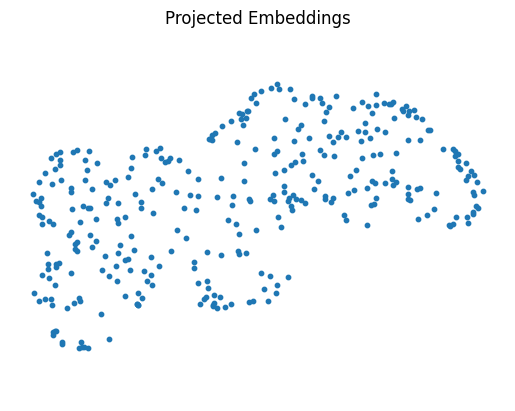

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Relevancy and Distraction

In [28]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [29]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 186.11it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

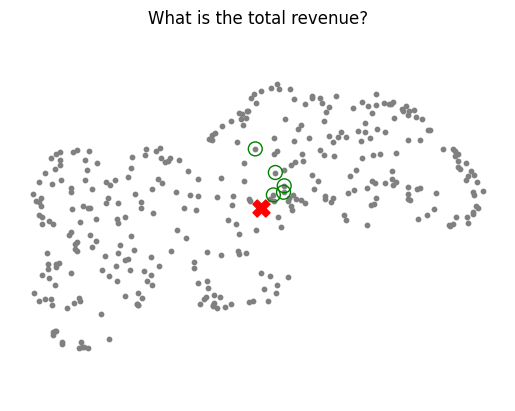

In [30]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [31]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [32]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 547.75it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

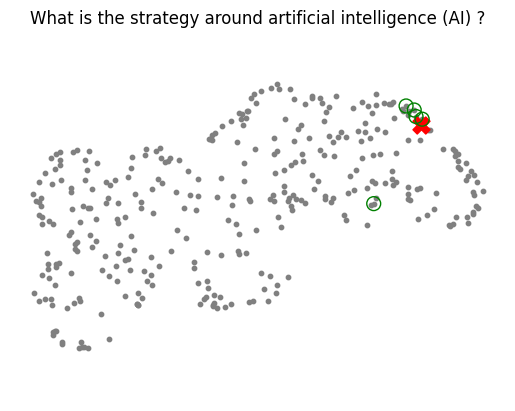

In [33]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')